#Features evaluation
This notebook is designed to evaluate the effect of using different features for audio classification.

We aim to do a straight classification on a dataset of 4 second audio snippets, each with a ground truth class label, e.g. 'bird' or 'fox'. 

We use a random forest for all the comparisons; other classifiers are available.

Running this entire notebook takes about 10 minutes on an 8-core desktop. A good speedup could be achieved by parallelising the feature computation, which currently takes about four minutes. The training and testing of the models takes most of the time, and this is already multi-core.

## Specific dependencies
- sklearn 0.16 or above (for class weighting in random forest)
- mfcc features (from https://github.com/jameslyons/python_speech_features)

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import collections
import time

import scipy.io.wavfile
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier

import sys, os
sys.path.append(os.path.expanduser('~/projects/engaged_hackathon/'))
from engaged.features import features as engaged_features
from engaged.features import frequency

# mfcc features from: https://github.com/jameslyons/python_speech_features
from features import mfcc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# this sets where the data is stored
base_path = '/home/michael/projects/engaged_hackathon_data/raw_data/cropped_audio/'

spectrogram_parameters = {
    'nfft': 1024,
    'window_width': 0.03,
    'overlap': 0.01,
#     'convert_to_mel': True,
#     'mel_bins': 50,
#     'stowell_normalise': True
    }

# we won't bother training OR testing on classes with fewer data than this number:
minimum_class_count = 10

## Reading csv and counting the number of each class in the dataset
Here we loop through the dataset once to get the count of each class. See also the `dataset_overview` notebook for a proper analysis of class frequency in the dataset.

In [12]:
filelist = csv.reader(open(base_path + 'below12kHz_cropped_label.txt'))

# dataset is a list of dictionaries, each of which represents one wav file
dataset = [{'wavpath':        f[0], 
            'start_time':     f[1], 
            'class':          f[2].lower().strip(),
            'base_filename':  '_'.join(f[0].split('_')[:3])
           }
           for f in filelist]

print "There are %d items in the original dataset" % len(dataset)

# counting how many of each class occur in the dataset
Y_all = [datum['class'] for datum in dataset]
class_counts = collections.Counter(Y_all)

# remove classes from the dataset which do not occur enough times
dataset = [datum for datum in dataset 
           if class_counts[datum['class']] >= minimum_class_count]

print "There are %d items in the dataset after removing small classes" % len(dataset)

There are 9144 items in the original dataset
There are 9116 items in the dataset after removing small classes


## Loading data and computing different types of features
For each wav file in the dataset, compute a few different types of features. Instead of loading all the data into memory first, each wav file is loaded one at a time. This reduces the memory load at the expense of repeating I/O operations if the notebook is run multiple times.

TODO - make parrallel, for speed gains

In [13]:
tic = time.time()

# list of class labels
Y = []  

# List of features. Each item in the list is a dict with an entry for each feature type
# features = []

def process_datum(idx_datum):

    # unpack input arguments
    count, data_item = idx_datum
    # add to the list of classes
#     Y.append(data_item['class'])
    
    # load in sound file and convert to spectogram  
    sr, wav = scipy.io.wavfile.read(base_path + data_item['wavpath'])  
    spec, spec_sample_rate = frequency.spectrogram(wav, sr, **spectrogram_parameters)
    
    mel_spec = frequency.spec_to_mel(spec, sr, 100)
    
    # ---------------------------------------------
    # FEATURE COMPUTATION
    
    mfcc_feats = mfcc(wav, sr, ceplifter=0, preemph=0, numcep=13)
    accumulated_mfcc_features = np.hstack(
        [mfcc_feats.mean(0), mfcc_feats.var(0), mfcc_feats.max(0)])
    
    featureset = {
        #  Simply make the spectrogram small, each pixel is a feature bin
        'resized_spectrogram': engaged_features.small_spectrogram(spec),
        
        # Max bins: Find the maximum frequency at each time step
        'max_bins': engaged_features.max_bins(spec[1:, :]),
        
        # MFCC features    
        'mfcc': accumulated_mfcc_features,
        
        # similar to small_spectrogram, but take the maximum value in each bin
        'max_pooling': engaged_features.small_spectrogram_max_pooling(spec[1:, :]),

        # take the max, mean and var along each strip of the spectrogram
        'frequency_max_pooling': engaged_features.frequency_max_pooling(spec[1:, :], blocks=True),

        # same as above but no normalisation
        'freq_max_pool_no_norm': engaged_features.frequency_max_pooling(spec[1:, :], False, blocks=True),
            
        # like before but with the mel spectrogram
        'frequency_max_pool_mel': engaged_features.frequency_max_pooling(mel_spec, blocks=False),
        'freq_max_pool_no_norm_mel': engaged_features.frequency_max_pooling(mel_spec, False, blocks=False),
        'max_bin_mel': engaged_features.mel_max_bins(mel_spec),
        
        # frequency responses
        'gauss_filters_3': engaged_features.gauss_filter_max_pooling(spec[1:, :], deviation=3, blockheight=16),
        'gauss_filters_6': engaged_features.gauss_filter_max_pooling(spec[1:, :], deviation=6, blockheight=16),
        'gauss_filters_9': engaged_features.gauss_filter_max_pooling(spec[1:, :], deviation=9, blockheight=16),
            
        # map of the spectrogram around the peak, using default params
        'peak_map': engaged_features.peak_map(spec)
        
        # computing a bag of words histogram over the spectrogram
#         'bow_hist': engaged_features.bow_hist(spec, bow_dict)
    }
   
    # Keep us updated on progress
    if count % 100 == 0:
        print count, 

    return data_item['class'], featureset
    
    # ---------------------------------------------
   
        
    # Uncomment this to do a 'small' run with only a few examples
#     if count >= 500:
#         break

if False:
    import multiprocessing
    pool = multiprocessing.Pool(8)
    XY = pool.map(process_datum, enumerate(dataset))
else:
    XY = map(process_datum, enumerate(dataset))

Y, features = zip(*XY)

print 'Feature computation took: %.2f s' % (time.time() - tic)

0 100 200 300 400 500 600 700 800 900 1000 1100 1200 1300 1400 1500 1600 1700 1800 1900 2000 2100 2200 2300 2400 2500 2600 2700 2800 2900 3000 3100 3200 3300 3400 3500 3600 3700 3800 3900 4000 4100 4200 4300 4400 4500 4600 4700 4800 4900 5000 5100 5200 5300 5400 5500 5600 5700 5800 5900 6000 6100 6200 6300 6400 6500 6600 6700 6800 6900 7000 7100 7200 7300 7400 7500 7600 7700 7800 7900 8000 8100 8200 8300 8400 8500 8600 8700 8800 8900 9000 9100 Feature computation took: 3117.85 s


In [14]:
# convert list of dictionaries of features to dictionary of numpy arrays
X = collections.defaultdict(list)

for datum_feature in features:
    for feature_name, feature_vector in datum_feature.items():
        X[feature_name].append(feature_vector)

for name, x in X.iteritems():
    # I hope it's ok to modify the *values* of a dictionary while iterating
    X[name] = np.vstack(x)
    print "Feature matrix \"%s\" has shape (%d, %d)" % (name, X[name].shape[0], X[name].shape[1])

Feature matrix "resized_spectrogram" has shape (9116, 100)
Feature matrix "frequency_max_pool_mel" has shape (9116, 300)
Feature matrix "mfcc" has shape (9116, 39)
Feature matrix "freq_max_pool_no_norm" has shape (9116, 192)
Feature matrix "max_bins" has shape (9116, 80)
Feature matrix "max_pooling" has shape (9116, 192)
Feature matrix "max_bin_mel" has shape (9116, 80)
Feature matrix "gauss_filters_3" has shape (9116, 192)
Feature matrix "peak_map" has shape (9116, 170)
Feature matrix "gauss_filters_6" has shape (9116, 192)
Feature matrix "gauss_filters_9" has shape (9116, 192)
Feature matrix "freq_max_pool_no_norm_mel" has shape (9116, 300)
Feature matrix "frequency_max_pooling" has shape (9116, 192)


In [15]:
for ff in features:
    print ff['peak_map'].shape

(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)
(170,)

## Training and testing the models for each feature type
The aim is to see how good each set of features is for classification.
We run a different experiment for each set of features. We also run an experiment which combines all the features together.
To remove dependancy on the train-test split used, we repeat this for 50 different train test splits.

To account for imbalance in the training set, we use the `class_weight` functionality of `sklearn.ensemble.RandomForestClassifier`. This was introduced in sklearn 0.16.


**TODO - we should really split by file not just by instance**

In [16]:
# doing proper train/test splits on the data
def train_test_split_file_level(superclass_labels, *arrays, **options):
    """
    Does a train/test split at the superclass level, where each superclass
    will typically contain more than one training instance.
    This is useful e.g. if the testing data each come from one of a few files,
    and we want to make sure that data from one file do not straddle the train/test 
    split. The split in this case would be done at a *file* level.
    
    Otherwise this should operate approximately like sklearn's train_test_split,
    except that the train/test percentages are done at the superclass level.
    """
        
    superclass_labels = np.array(superclass_labels)
    N = superclass_labels.shape[0]
    
    for array in arrays:
        assert np.array(array).shape[0] == N 
    
    # create a dictionary mapping a superclass label to a list of the 
    # instance idxs which have that superclass label
    superclass_to_idx = collections.defaultdict(list)
    for count, superclass_label in enumerate(superclass_labels):
        superclass_to_idx[superclass_label].append(count)
   
    # do a train/test split at superclass level
    train_superclasses, test_superclasses = train_test_split(
        list(set(superclass_labels)), **options)
            
    # convert this to a train/test split at the instance level
    all_training = []
    for filename in train_superclasses:
        all_training.extend(superclass_to_idx[filename])

    all_testing = []
    for filename in test_superclasses:
        all_testing.extend(superclass_to_idx[filename])

    # checking no train/test overlap
    assert len(set(all_testing).intersection(set(all_training))) == 0

    # splitting each of the arrays
    output = []
    for array in arrays:
        output.append([array[idx] for idx in all_training])
        output.append([array[idx] for idx in all_testing])
    
    return output

In [17]:
# setting up a dictionary of experiments to run
# keys are names of this experiment
# values are a list of all the features to test on for this experiment
import random 
tic = time.time()

# set up experiments for sets of features
experiments = {
    'all_nonmel': ['freq_max_pool_no_norm', 'frequency_max_pooling', 'max_pooling', 'max_bins'],
    'all_mel': ['freq_max_pool_no_norm_mel', 'frequency_max_pool_mel', 'max_bin_mel'],
    'all': ['mfcc', 'resized_spectrogram', 'max_bins', 'max_pooling', 'frequency_max_pooling', 
            'freq_max_pool_no_norm', 'frequency_max_pool_mel', 'max_bin_mel']
    }

# add an experiment for each feature type
for xx in X:
    if len(xx) > 1:
        experiments[xx] = [xx]

# a list of the *original* file from which each recording came 
source_files = [datum['base_filename'] for datum in dataset]

# set up a dictionary to store the results. Uses DefaultDict: 
# https://docs.python.org/2/library/collections.html#defaultdict-examples
results = collections.defaultdict(list)

# we will repeat the experiment for multiple train/test splits, and ultimately
# average over them
for random_seed in range(4, 10):
    
    print "Seed", random_seed,
    
    # splitting data by the original filename, not just by instance
    temp_train_idxs, temp_test_idxs = train_test_split_file_level(
        source_files, range(len(Y)), random_state=random_seed)
    
    # resample the training classes to have a maximum of 50 of each class
    train_idxs = []
    class_counts = collections.defaultdict(int)
    random.shuffle(temp_train_idxs)  # shuffle the training data in place to get a good spread
    for idx in temp_train_idxs:
        # only add to the new list if we haven't had enough yet
        if class_counts[Y[idx]] < 100:
            train_idxs.append(idx)
            
        class_counts[Y[idx]] += 1
        
    Y_train = [Y[idx] for idx in train_idxs]
    
    # count the classes in the training set
    training_class_counts = collections.Counter(Y_train)
    temp_test_class_counts = \
        collections.Counter([Y[idx] for idx in temp_test_idxs])
    
    # only use test classes which appear in the training set enough times!
    # ...and which are in the test set enough times! 
    test_idxs = [
        idx for idx in temp_test_idxs 
        if training_class_counts[Y[idx]] > minimum_class_count 
        and temp_test_class_counts[Y[idx]] > minimum_class_count]
    Y_test = [Y[idx] for idx in test_idxs]
    
    # Set a baseline where all the test set is classified as bird
    all_bird = {'Y_pred': ['bird'] * len(Y_test), 'Y_test': Y_test}
    results['classify_all_as_bird'].append(all_bird)
            
    # loop over each experiment
    for experiment_name, feature_list in experiments.iteritems():

        # concatenating all the feature vectors for this experiment together
        X_np = np.hstack([X[feat_name] for feat_name in feature_list])

        X_train = X_np[train_idxs]
        X_test = X_np[test_idxs]

        # training a classifier on these features and then testing on test set
        rf = RandomForestClassifier(
            n_estimators=100,     # number of trees in forest
            class_weight='auto',  # to help account for imbalance in training set
            n_jobs=-1,            # to make parallel
            max_features=None)    # at each node, check *all* the features for a good split
        rf.fit(X_train, Y_train)
        Y_pred = rf.predict(X_test)
                
        # adding this result to the results dictionary
        this_result = {'Y_test': Y_test, 'Y_pred': list(Y_pred), 'model': rf}
        results[experiment_name].append(this_result)
        
print '\nTotal time for train/test of models is: %.2f s' % (time.time() - tic)

Seed 4 Seed 5 Seed 6 Seed 7 Seed 8 Seed 9 
Total time for train/test of models is: 710.02 s


In [18]:
for class_name, count in collections.Counter(Y_train).iteritems():
    print class_name.ljust(30) + str(count)

bat                           19
bus emitting                  15
dog bark                      34
wing beats                    30
fox                           17
braking                       100
anthropogenic unknown         100
metal                         29
mix traffic                   100
voices                        100
beep                          35
whistle                       6
unknown sound                 100
electrical                    100
rain                          100
blank                         100
airplane                      45
mower                         11
footsteps                     1
bird                          100
grey squirrel                 11


## Evaluating accuracy of approaches
We report two accuracy measures:

1. **Unnormalised accuracy**: This is simply the fraction of the test items which have been correctly labelled. This is simple, but is biased by imbalanced classes. E.g. if 80% of the test dataset are labelled as 'bird', you can achieve 80% accuracy easily simply by labelling everything as 'bird'.

2. **Class-normalised accuracy**: This measure mitigates against these problems by reporting the average accuracy *per-class*. This means that we find the accuracy for all the items with a ground truth label of 'bird', the accuracy for the items with a ground truth label of 'bat', etc. We then average all these scores to find the final number.

Experiment name               Unnormalised accuracy   Normalised accuracy 
---------------------------------------------------------------------------
all                           0.366			 0.395
all_nonmel                    0.331			 0.392
gauss_filters_3               0.359			 0.375
gauss_filters_9               0.386			 0.375
gauss_filters_6               0.384			 0.377
all_mel                       0.338			 0.360
freq_max_pool_no_norm_mel     0.338			 0.361
frequency_max_pool_mel        0.338			 0.360
max_pooling                   0.272			 0.345
freq_max_pool_no_norm         0.312			 0.339
frequency_max_pooling         0.313			 0.330
mfcc                          0.300			 0.302
max_bins                      0.254			 0.253
max_bin_mel                   0.166			 0.191
resized_spectrogram           0.174			 0.182
peak_map                      0.161			 0.178
classify_all_as_bird          0.562			 0.083


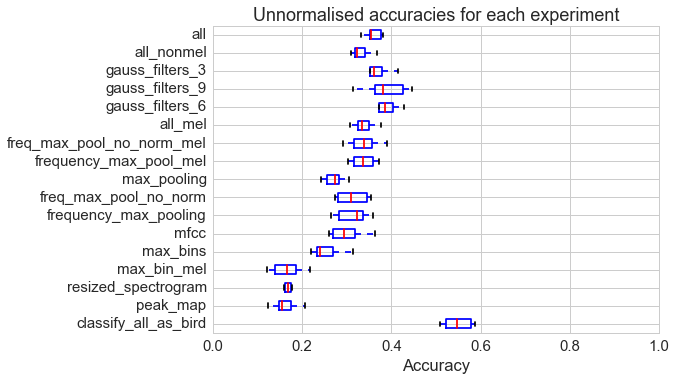

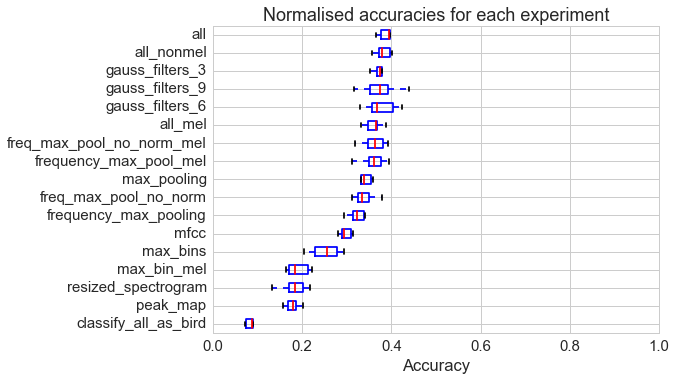

In [19]:
import sklearn.metrics
sns.set(style = 'whitegrid', font_scale=1.5)

def unnormalised_accuracy(Y_pred, Y_ground_truth):
    """
    This is simply the fraction of the test data which have been correctly labelled
    """
    return sklearn.metrics.accuracy_score(Y_pred, Y_ground_truth)


def class_normalised_accuracy(Y_pred, Y_ground_truth):
    """
    This is the average fraction of each class in the ground truth examples 
    which were correctly labelled.
    This helps to remove bias caused by large imbalance in class labels in 
    the testing set
    """
    correct_label_count = collections.defaultdict(int)
    total_label_count = collections.defaultdict(int)
    
    # for each prediction, update the number of correct vs total labels
    for y_pred, y_ground_truth in zip(Y_pred, Y_ground_truth):
        
        total_label_count[y_ground_truth] += 1

        if y_pred == y_ground_truth:
            correct_label_count[y_ground_truth] += 1
        
    # compute a final per-class accuracy
    these_accs = []
    for class_name, total_count in total_label_count.iteritems():
        correct_count = correct_label_count[class_name]
        these_accs.append(float(correct_count) / float(total_count))
    
    # return the mean per-class accuracy
    return np.array(these_accs).mean()


accuracies = []

# Find the accuracy of each feature type
for experiment_name, result_list in results.iteritems():
    
    # get a list of all the accuracy results for each train/test split
    unnormalised_acc = [unnormalised_accuracy( result['Y_pred'], result['Y_test']) 
           for result in result_list]

    class_normalised_acc = [class_normalised_accuracy( result['Y_pred'], result['Y_test']) 
           for result in result_list]

    accuracies.append((experiment_name, unnormalised_acc, class_normalised_acc))
    
# sorting the list of accuracies by median accuracy
accuracies = sorted(accuracies, key=lambda x: np.median(np.array(x[2])))

# printing this sorted list
print "Experiment name".ljust(30) + "Unnormalised accuracy".ljust(24) + \
    "Normalised accuracy".ljust(20)

print '-' * 75

for experiment_name, acc1, acc2 in accuracies[::-1]:
    print experiment_name.ljust(30) + '%0.3f\t\t\t %0.3f' % \
        (np.array(acc1).mean(), np.array(acc2).mean())

plt.boxplot([acc[1] for acc in accuracies], 0, 'b+', 0);
plt.xlim(0, 1.0)
plt.xlabel('Accuracy')
plt.title('Unnormalised accuracies for each experiment')
plt.gca().set_yticklabels([acc[0] for acc in accuracies]);

plt.figure()
plt.boxplot([acc[2] for acc in accuracies], 0, 'b+', 0);
plt.xlim(0, 1.0)
plt.xlabel('Accuracy')
plt.title('Normalised accuracies for each experiment')
plt.gca().set_yticklabels([acc[0] for acc in accuracies]);

## Confusion matrix
Only plotting for one run of the results.

- Experiment type: `all`, i.e. with all the features used
- Zeroth train/test split

i.e. `results['all'][0]['Y_pred']`

We plot two confusion matrices:

- **Unnormalised**: Standard confusion matrix (https://en.wikipedia.org/wiki/Confusion_matrix)
- **Normalised**: Each row normalised to sum to one.

**TODO - add number of each train/test class to the plot**

In [20]:
from sklearn.metrics import confusion_matrix
sns.set_style("white")

experiment_to_show = 'gauss_filters'

unique_labels = list(set(Y))

predictions = list(results[experiment_to_show][0]['Y_pred'])
ground_truth = results[experiment_to_show][0]['Y_test']

cm = confusion_matrix(ground_truth, predictions, labels=unique_labels)
cm_normalized = cm.astype('float') / cm.astype('float').sum(axis=1)[:, np.newaxis]

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(unique_labels))
    plt.xticks(tick_marks, unique_labels, rotation=75)
    
    label_counts = collections.Counter(ground_truth)
    print label_counts
    true_labels = [label + ' (' + str(label_counts[label]) + ')' 
                   for label in unique_labels]
    
    plt.yticks(tick_marks, true_labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm_normalized, 
  title='Normalised confusion matrix for experiment: ' + experiment_to_show + '');

plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, 
  title='Unnnormalised confusion matrix for experiment: ' + experiment_to_show + '');

IndexError: list index out of range

In [23]:
# It would be able to be able to run the following:

import IPython
IPython.display.Audio(wav, rate=sr)

def play_example_sound(true_label, predicted_label):
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
    
play_example_sound(true_label='anthropogenic unknown', predicted_label='airplane')


NameError: name 'wav' is not defined

## Feature importances from the random forest

In [ ]:
# plotting feature importances for each dimension of the frequency_max_pooling model 
plt.figure(figsize=(10, 3))

# find the average feature importance over each split of the data
importances = [result['model'].feature_importances_ 
               for result in results['frequency_max_pooling']]
importances = np.vstack(importances).mean(0)
               
# plot a dot for each point
n = len(importances)/3
plt.plot(range(n), importances[:n], '.-r', label='Maximum')
plt.plot(range(n, 2*n), importances[n:2*n], '.-g', label='Variance')
plt.plot(range(2*n, 3*n), importances[2*n:3*n], '.-b', label='Mean')
plt.title(experiment_to_show)
plt.legend()
plt.ylabel('Importance')
plt.xlabel('Feature')

In [ ]:
# plotting feature importances for each dimension of the frequency_max_pooling model 
plt.figure(figsize=(10, 4))

# find the average feature importance over each split of the data
importances = [result['model'].feature_importances_ 
               for result in results['gauss_filters']]
# print results['gauss_filters']
importances = np.vstack(importances).mean(0)
print importances.shape
               
# plot a dot for each point
n = len(importances)/6
plt.plot(importances[:n], '.-r', label='Filt0')
plt.plot(importances[n:2*n], '.-g', label='Filt1')
plt.plot(importances[2*n:3*n], '.-b', label='Filt2')
plt.plot(importances[3*n:4*n], '.-k', label='Filt3')
plt.plot(importances[4*n:5*n], '.-c', label='Filt4')
plt.plot(importances[5*n:], '-b', label='Filt5')
plt.title(experiment_to_show)
plt.legend()
plt.ylabel('Importance')
plt.xlabel('Feature')
